In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
from read_json import read_json  # for json files
import numpy as np
from plots import plot_histogram
from datetime import datetime
from scipy.fftpack import fft
import seaborn as sb
from numpy.linalg import norm



In [2]:
servers = ['DEVELOP','QASERVER','PRODUCCION', 'PREPRODUCCION','PRUEBAS']
def correlation(name):
    data = pd.read_csv("resampled/" + name + "_resampled.csv")
    data = data.drop(["swap_norm","bytes_total","out_bytes","in_bytes","actual_used_bytes","free","actual_used_pct","swap_free","swap_total"],axis=1)
    hm = sb.heatmap(data.loc[:, data.columns != 'cores'].corr(), cmap="Blues", annot=True).set(title=name)

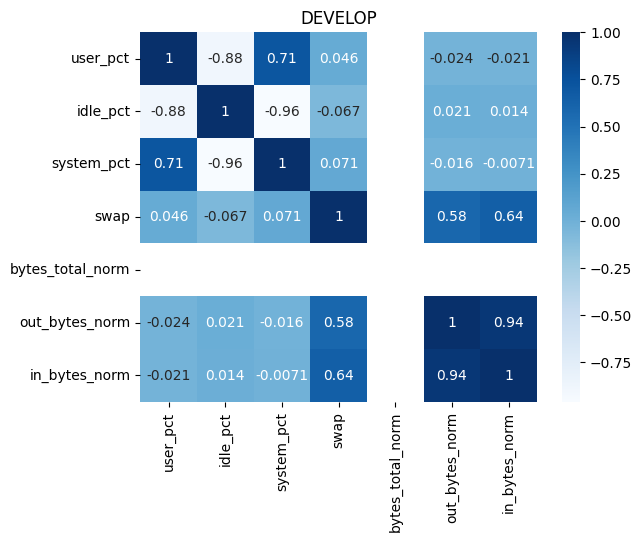

In [3]:
correlation(servers[0])

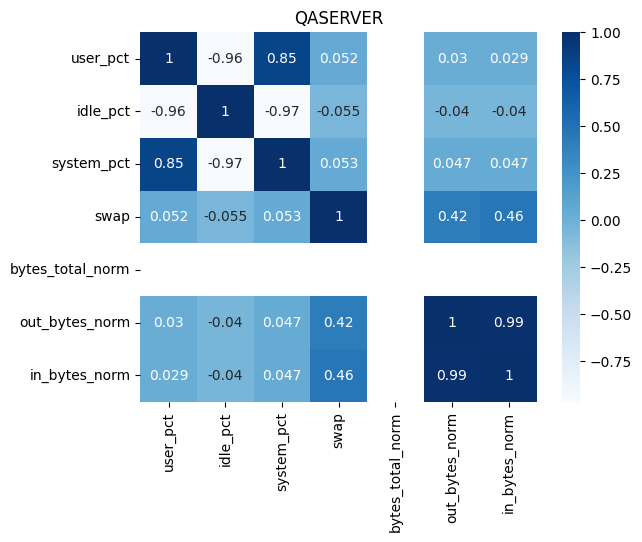

In [4]:
correlation(servers[1])

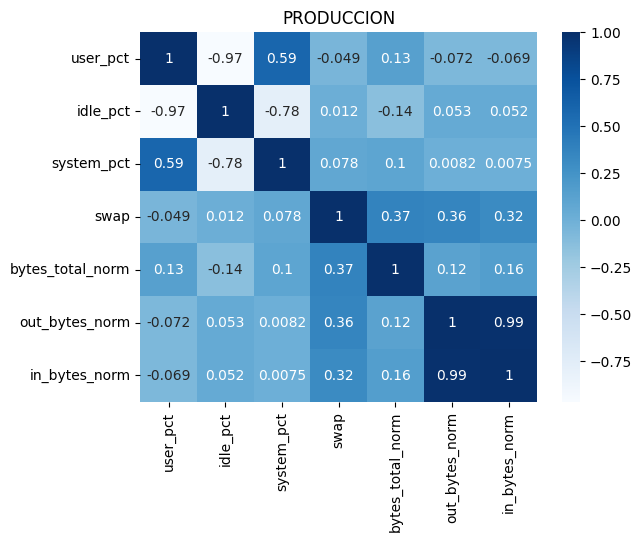

In [5]:
correlation(servers[2])

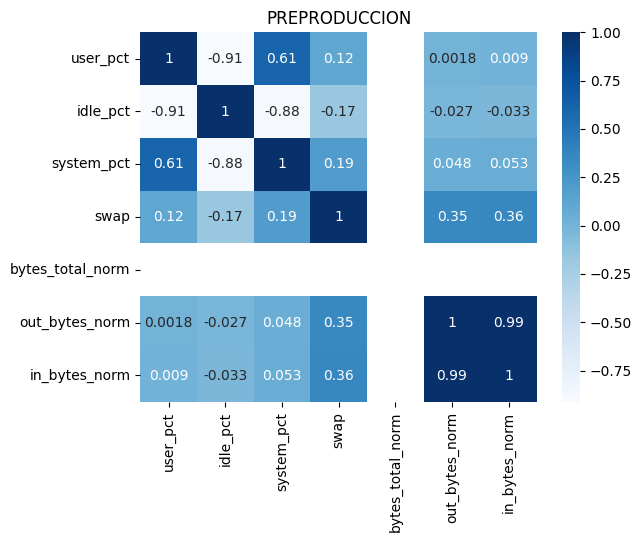

In [6]:
correlation(servers[3])

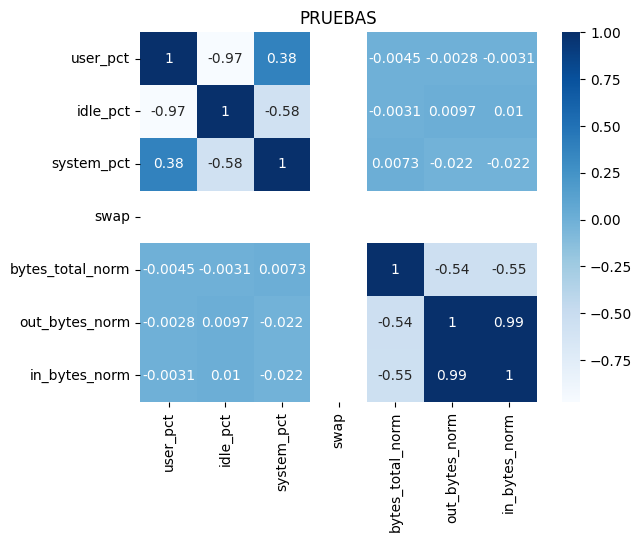

In [7]:
correlation(servers[4])

2
(4459,) (4459,) (4459,)


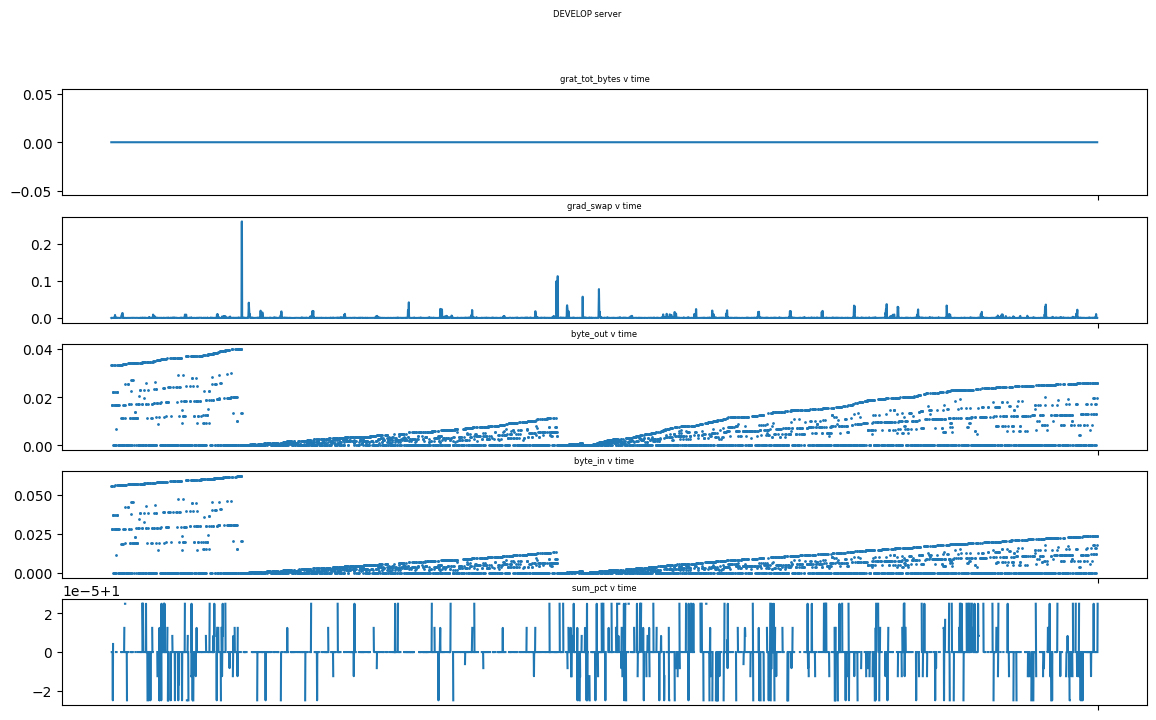

2
(4460,) (4460,) (4460,)


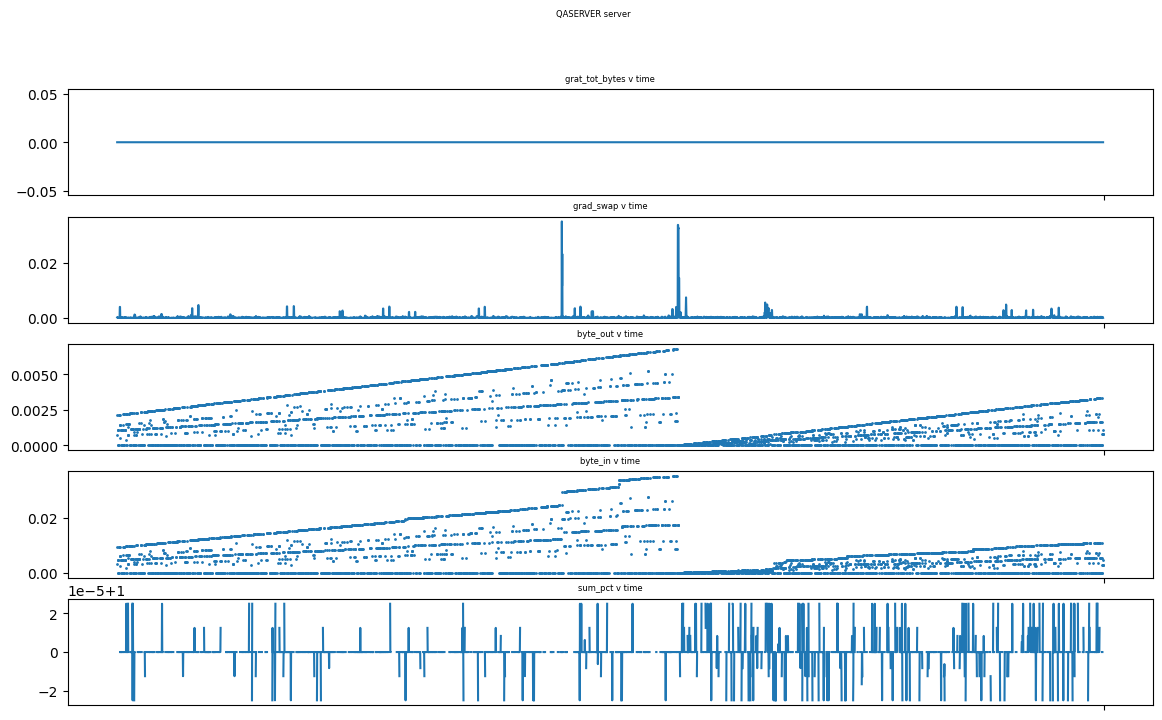

2
(4460,) (4460,) (4460,)


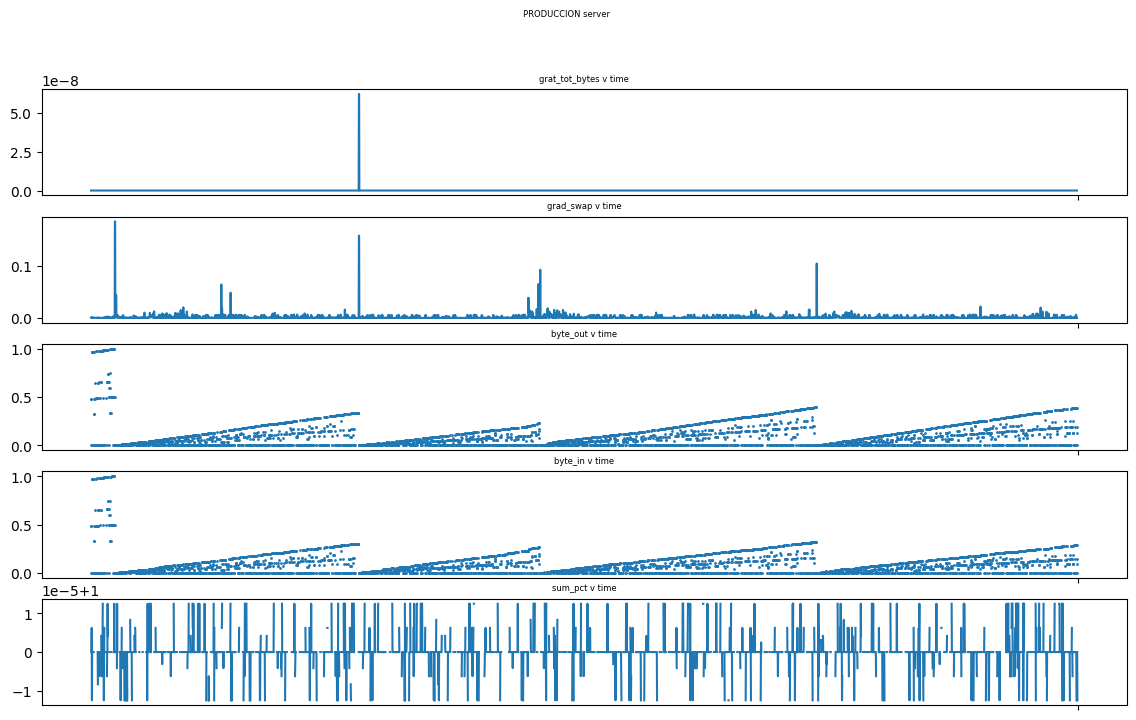

3
(4458,) (4458,) (4458,)


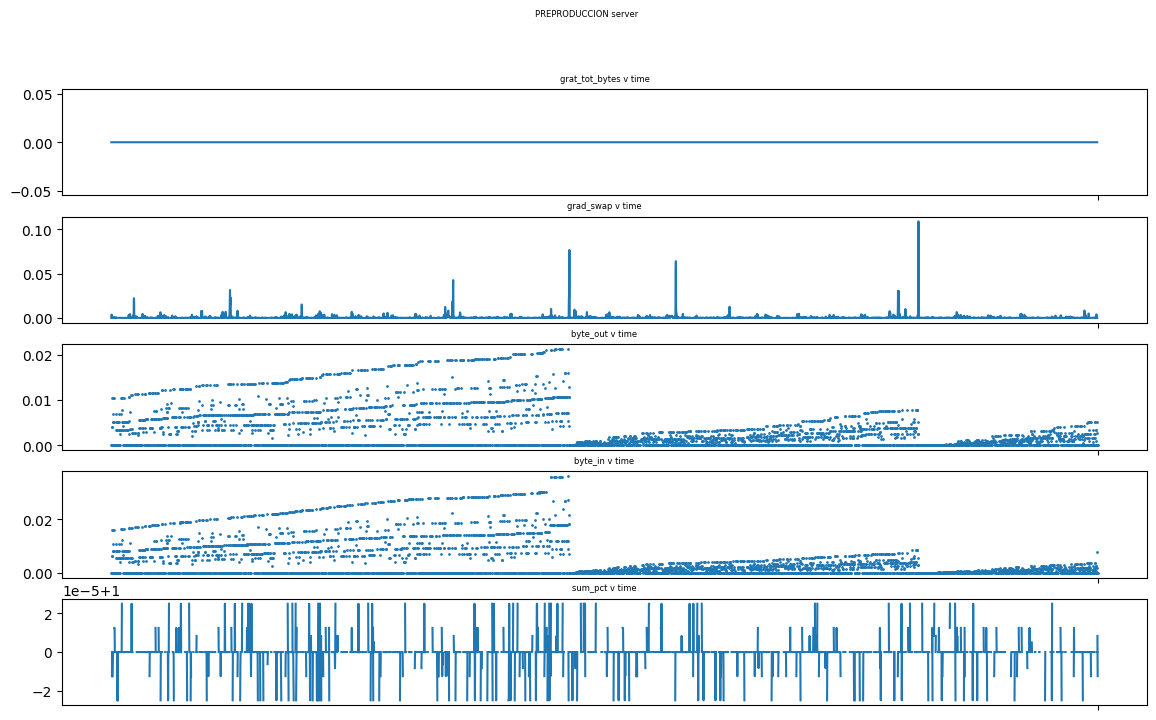

2
(4461,) (4461,) (4461,)


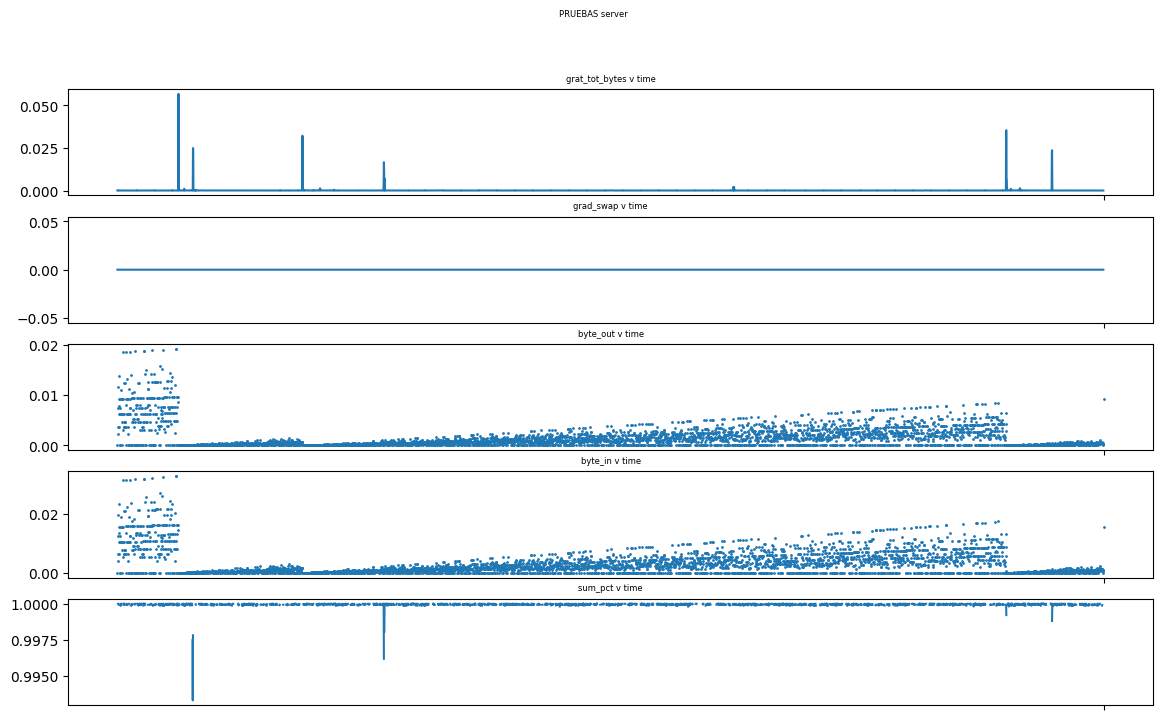

In [44]:
def plot(name):

    data = pd.read_csv("resampled/" + name + "_resampled.csv")
    data = data.drop(["swap_norm","bytes_total","out_bytes","in_bytes","actual_used_bytes","free","actual_used_pct","swap_free"],axis=1)

    time = data["@timestamp"]
    time_tick = [""]#data["@timestamp"][::500]

    user_pct = data["user_pct"]
    idle_pct = data["idle_pct"]
    system_pct = data["system_pct"]
    swap = data["swap"]
    bytes_total_norm = data["bytes_total_norm"]
    out_bytes_norm = data["out_bytes_norm"]
    in_bytes_norm = data["in_bytes_norm"]
    
    N_bytes_total_norm = np.zeros((len(out_bytes_norm),1))
    C_bytes_tot = 0
    N_out_bytes = np.zeros((len(out_bytes_norm),1))
    C_bytes_out = 0
    N_in_bytes = np.zeros((len(out_bytes_norm),1))
    C_bytes_in = 0
    N_swap = np.zeros((len(out_bytes_norm),1))
    C_swap = 0

    for i in range(len(out_bytes_norm)):
        if (np.isnan(out_bytes_norm[i])==True):
            if i != 0:
                N_out_bytes[i] = N_out_bytes[i-1]
            else:
                N_out_bytes[i] = 0
        elif (C_bytes_out == 0):
            N_out_bytes[i] = out_bytes_norm[i]
            C_bytes_out = i
        else:
            N_out_bytes[i] = out_bytes_norm[i]

        if (np.isnan(in_bytes_norm[i])==True):
            if i != 0:
                N_in_bytes[i] = N_in_bytes[i-1]
            else:
                N_in_bytes[i] = 0
        elif(C_bytes_in == 0):
            N_in_bytes[i] = in_bytes_norm[i]
            C_bytes_in = i
        else:
            N_in_bytes[i] = in_bytes_norm[i]

        if (np.isnan(swap[i])==True):
            if i != 0:
                N_swap[i] = N_swap[i-1]
            else:
                N_swap[i] = 0
        elif(C_swap == 0):
            N_swap[i] = swap[i]
            C_swap = i
        else:
            N_swap[i] = swap[i]

        if (np.isnan(bytes_total_norm[i])==True):
            if i != 0:
                N_bytes_total_norm[i] = N_bytes_total_norm[i-1]
            else:
                N_bytes_total_norm[i] = 0
        elif(C_bytes_tot == 0):
            N_bytes_total_norm[i] = bytes_total_norm[i]
            C_bytes_tot = i
        else:
            N_bytes_total_norm[i] = bytes_total_norm[i]

    grad_tot_byte = np.abs(np.gradient(N_bytes_total_norm[C_bytes_tot+1:].flatten()))
    grad_swap = np.abs(np.gradient(N_swap[C_swap + 1:].flatten()))
    
    pct_all = user_pct + system_pct + idle_pct

    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,sharex=True,figsize=(14,8))
    fig.suptitle(name + " server",fontsize = 6)

    ax1.plot(time[C_bytes_tot+1:], grad_tot_byte)
    ax1.set_title("grat_tot_bytes v time",fontsize = 6)

    ax2.plot(time[C_swap+1:], grad_swap)
    ax2.set_title("grad_swap v time",fontsize = 6)

    ax3.scatter(time[C_bytes_out:], N_out_bytes[C_bytes_out:],s=1)
    ax3.set_title("byte_out v time",fontsize = 6)

    ax4.scatter(time[C_bytes_in:], N_in_bytes[C_bytes_in:],s=1)
    ax4.set_title("byte_in v time",fontsize = 6)

    ax5.plot(time, pct_all)
    ax5.set_title("sum_pct v time",fontsize = 6)

    # ax6.plot(time, system_pct)
    # ax6.set_title("out_bytes_norm v time",fontsize = 6)

    # ax7.plot(time, idle_pct)
    # ax7.set_title("in_bytes_norm v time",fontsize = 6)

    Cs = np.array([C_bytes_tot+1,C_swap+1,C_bytes_out])
    Cmax = Cs.max()
    print(Cmax)

    grad_total_bytes_ne = grad_tot_byte[Cmax:]
    grad_Swap_ne = grad_swap[0:len(grad_total_bytes_ne)]
    out_bytes_ne = N_out_bytes[0:len(grad_total_bytes_ne)]

    print(grad_Swap_ne.shape,grad_Swap_ne.shape,out_bytes_ne[:,0].shape)

    d = {'grad_total_bytes': grad_total_bytes_ne, 'grad_Swap': grad_Swap_ne, 'out_bytes':out_bytes_ne[:,0]}
    df = pd.DataFrame(data=d, index=time[0:len(grad_total_bytes_ne)])
    df.to_csv(name + "_machine_learning_charlie")

    plt.xticks(rotation=30)
    plt.xticks(time_tick)
    plt.show()
    return "cum"

def start():
    servers = ['DEVELOP','QASERVER','PRODUCCION', 'PREPRODUCCION','PRUEBAS']
    for i in range(5):
        plot(servers[i])

start()